In [1]:
import pymysql
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
import shap

d:\2nd_round\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [112]:
query = '''
SELECT
    m.chembl_id                 AS compound_chembl_id,
    cs.canonical_smiles         AS smiles,

    t.chembl_id                 AS target_chembl_id,
    t.pref_name                AS target_name,
    t.organism,

    a.standard_type,
    a.standard_value           AS activity_nM,
    a.standard_units,
    a.pchembl_value,

    c.mw_freebase,
    c.alogp,
    c.hba,
    c.hbd,
    c.psa,
    c.rtb,
    c.aromatic_rings,
    c.heavy_atoms

FROM activities a

JOIN assays s
  ON a.assay_id = s.assay_id

JOIN target_dictionary t
  ON s.tid = t.tid

JOIN molecule_dictionary m
  ON a.molregno = m.molregno

JOIN compound_structures cs
  ON m.molregno = cs.molregno

JOIN compound_properties c
  ON m.molregno = c.molregno

WHERE
      a.standard_type IN ('IC50','EC50')
  AND a.standard_units = 'nM'
  
  AND a.standard_relation = '='

  AND a.potential_duplicate = 0
  AND s.confidence_score >= 5;

'''

In [113]:
conn = pymysql.connect(
    host="localhost",
    user="root",
    passwd="password",
    db="yash",
    charset="utf8mb4"
)


chunksize = 200_000

dfs = []

for chunk in pd.read_sql(query, conn, chunksize=chunksize):
    dfs.append(chunk)

conn.close()

df = pd.concat(dfs, ignore_index=True)

print(df.shape)


C:\Users\yashd\AppData\Local\Temp\ipykernel_13664\1911090587.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql(query, conn, chunksize=chunksize):


(1551640, 17)


In [114]:
# df.to_csv(r'..\data\chemical_data_null.csv', index=False)

In [2]:
df = pd.read_csv(r'D:\data\chemical_data_null.csv')

In [3]:
df.head(3)

,compound_chembl_id,smiles,target_chembl_id,target_name,organism,standard_type,activity_nM,standard_units,pchembl_value,mw_freebase,alogp,hba,hbd,psa,rtb,aromatic_rings,heavy_atoms,qed_weighted
0,CHEMBL324340,Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)...,CHEMBL3921,Heparanase,Homo sapiens,IC50,2500.0,nM,5.60,398.37,4.30,5.0,1.0,100.71,3.0,4.0,30.0,0.52
1,CHEMBL109600,COc1ccccc1-c1ccc2oc(-c3ccc(OC)c(N4C(=O)c5ccc(C...,CHEMBL3921,Heparanase,Homo sapiens,IC50,9000.0,nM,5.05,520.50,5.68,7.0,1.0,119.17,6.0,5.0,39.0,0.28
2,CHEMBL357278,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4ccc(Cl)c(C(...,CHEMBL4632,Peroxisomal acyl-coenzyme A oxidase 1,Rattus norvegicus,IC50,4000.0,nM,5.40,543.01,4.27,7.0,2.0,77.93,8.0,3.0,36.0,0.44


In [4]:
df[['target_chembl_id']].value_counts().head(10)

target_chembl_id
CHEMBL203           17191
CHEMBL2971          12782
CHEMBL1741186       12616
CHEMBL5251          11785
CHEMBL279           11722
CHEMBL4822          11052
CHEMBL1163125       10800
CHEMBL240           10675
CHEMBL2835           9651
CHEMBL4296           9180
Name: count, dtype: int64

# Target finalization


In [5]:
# Targeting target_chembl_id 'CHEMBL279' (Vascular endothelial growth factor receptor 2)
df = df[(df['target_chembl_id']=='CHEMBL279') & (df['organism']=='Homo sapiens')].reset_index(drop=True)
df.shape

(11722, 18)

In [6]:
df.head(2)

,compound_chembl_id,smiles,target_chembl_id,target_name,organism,standard_type,activity_nM,standard_units,pchembl_value,mw_freebase,alogp,hba,hbd,psa,rtb,aromatic_rings,heavy_atoms,qed_weighted
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,CHEMBL279,Vascular endothelial growth factor receptor 2,Homo sapiens,IC50,16500.0,nM,4.78,383.81,4.45,4.0,3.0,82.70,3.0,3.0,27.0,0.58
1,CHEMBL69638,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,CHEMBL279,Vascular endothelial growth factor receptor 2,Homo sapiens,IC50,7100.0,nM,5.15,370.46,5.59,5.0,1.0,65.96,4.0,4.0,28.0,0.51


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11722 entries, 0 to 11721
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   compound_chembl_id  11722 non-null  object 
 1   smiles              11722 non-null  object 
 2   target_chembl_id    11722 non-null  object 
 3   target_name         11722 non-null  object 
 4   organism            11722 non-null  object 
 5   standard_type       11722 non-null  object 
 6   activity_nM         11721 non-null  float64
 7   standard_units      11722 non-null  object 
 8   pchembl_value       11666 non-null  float64
 9   mw_freebase         11722 non-null  float64
 10  alogp               11671 non-null  float64
 11  hba                 11671 non-null  float64
 12  hbd                 11671 non-null  float64
 13  psa                 11671 non-null  float64
 14  rtb                 11671 non-null  float64
 15  aromatic_rings      11671 non-null  float64
 16  heav

In [8]:
df.isna().sum()

compound_chembl_id     0
smiles                 0
target_chembl_id       0
target_name            0
organism               0
standard_type          0
activity_nM            1
standard_units         0
pchembl_value         56
mw_freebase            0
alogp                 51
hba                   51
hbd                   51
psa                   51
rtb                   51
aromatic_rings        51
heavy_atoms           51
qed_weighted          51
dtype: int64

In [9]:
df['standard_units'].value_counts()

standard_units
nM    11722
Name: count, dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
activity_nM,11721.0,3624.968686,42630.920695,0.02,20.42,127.00,997.00,4081000.00
pchembl_value,11666.0,6.853978,1.131107,4.00,6.02,6.90,7.70,10.70
mw_freebase,11722.0,451.573334,83.986492,145.16,394.78,451.56,505.62,1788.97
alogp,11671.0,4.504078,1.257522,-2.47,3.68,4.51,5.38,9.41
hba,11671.0,6.301517,1.901336,1.00,5.00,6.00,8.00,16.00
hbd,11671.0,2.117899,1.158840,0.00,1.00,2.00,3.00,9.00
psa,11671.0,92.401121,24.401573,13.22,76.50,92.35,108.05,312.02
rtb,11671.0,6.012595,2.615902,0.00,4.00,6.00,8.00,28.00
aromatic_rings,11671.0,3.708937,0.836520,0.00,3.00,4.00,4.00,7.00
heavy_atoms,11671.0,32.309399,5.739114,11.00,28.00,32.00,36.00,67.00


### **Vascular endothelial growth factor receptor 2** `CHEMBL279`

- This protein is a receptor *tyrosine kinase* found on the surface of endothelial cells that binds **VEGF** (*Vascular Endothelial Growth Factor*).
- It is responsible for forming new blood vessels (angiogenesis) and maintain a healthy vascular development.
- Upon activation, it triggers signaling pathways that promotes cell growth of blood vessels.
- As it can generate new cells/blood vessels, abnormality might be seen, which can lead to cancer.
- Blocking this recptors, it *reduces the blood supply to tumors* and prevents harmfull vessel growth.

***Resource***: 
1. https://pmc.ncbi.nlm.nih.gov/articles/PMC7701214/
2. https://pmc.ncbi.nlm.nih.gov/articles/PMC12106596/

### Dataset basic info
- The dataset contains **~11.7k** drug-like molecules with typical properties (**MW ≈ 450**, **logP ≈ 4.5**, **TPSA ≈ 92**, **~4 aromatic rings**). 
- `Bioactivity` spans an extremely wide range (`0.02 `to `4,000,000 nM`), indicating the presence of both very potent and very weak compounds, which is ideal for learning structure–activity relationships, but 50% of the `Bioactivity` is below `130 nm`.

# Data Cleaning

In [11]:
df['smiles'].duplicated().sum()

np.int64(2074)

In [12]:
# Credit:- Data Professor

def identify_duplicates(df, smiles_column):
    """Identifies duplicate molecules in a dataset using SMILES strings."""
    def standardize_smiles(smiles):
        """Standardize SMILES to canonical form"""
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            return Chem.MolToSmiles(mol, canonical=True)
        except:
            return None

    def calculate_inchi_key(smiles):
        """Calculate InChI Key for a SMILES string"""
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            return Chem.MolToInchiKey(mol)
        except:
            return None

    # Create a copy of the dataframe
    df_analysis = df.copy()

    # Add standardized SMILES
    df_analysis['canonical_smiles'] = df_analysis[smiles_column].apply(standardize_smiles)

    # Add InChI Keys
    df_analysis['inchi_key'] = df_analysis['canonical_smiles'].apply(calculate_inchi_key)

    # Mark invalid SMILES
    df_analysis['is_valid'] = df_analysis['canonical_smiles'].notna()

    # Identify duplicates
    df_analysis['is_duplicate'] = df_analysis['inchi_key'].duplicated(keep='first')

    # Group duplicates
    df_analysis['duplicate_group'] = df_analysis.groupby('inchi_key').ngroup()

    # Count occurrences of each molecule
    duplicate_counts = df_analysis['inchi_key'].value_counts()
    df_analysis['occurrence_count'] = df_analysis['inchi_key'].map(duplicate_counts)

    return df_analysis

def get_duplicate_summary(df_analysis):
    """Generates a summary of duplicate analysis"""
    summary = {
        'total_molecules': len(df_analysis),
        'invalid_smiles': (~df_analysis['is_valid']).sum(),
        'unique_molecules': df_analysis['inchi_key'].nunique(),
        'duplicate_molecules': df_analysis['is_duplicate'].sum(),
        'molecules_with_duplicates': len(df_analysis[df_analysis['occurrence_count'] > 1]),
        'max_duplicates': df_analysis['occurrence_count'].max()
    }
    return summary

df_analysis = identify_duplicates(df, 'smiles')

get_duplicate_summary(df_analysis)

{'total_molecules': 11722,
 'invalid_smiles': np.int64(0),
 'unique_molecules': 9648,
 'duplicate_molecules': np.int64(2074),
 'molecules_with_duplicates': 3674,
 'max_duplicates': np.int64(50)}

In [13]:
# Credit:- Data Professor

def process_duplicates(df, inchi_key_col, pchembl_col):
    """Process duplicates with different handling for zero-SD and non-zero-SD groups."""
    # Create working copy
    df_work = df.copy()

    # Calculate group statistics
    group_stats = df_work.groupby(inchi_key_col).agg({
        pchembl_col: ['count', 'mean', 'std']
    }).round(4)

    group_stats.columns = ['count', 'mean', 'std']
    group_stats = group_stats.reset_index()

    # Filter for groups with multiple entries
    duplicate_groups = group_stats[group_stats['count'] > 1].copy()
    # Identify single entry compounds
    single_entry_groups = group_stats[group_stats['count'] == 1].copy()

    # Initialize list for processed rows and duplicates info
    processed_rows = []
    compounds_with_dups = []

    # Process each group
    for inchi_key in group_stats['inchi_key']:
        group_data = df_work[df_work[inchi_key_col] == inchi_key].copy()
        group_stats_row = group_stats[group_stats['inchi_key'] == inchi_key].iloc[0]

        if len(group_data) > 1:  # Multiple entries
            # Add statistics to group data
            group_data['group_mean'] = group_stats_row['mean']
            group_data['group_std'] = group_stats_row['std']
            compounds_with_dups.append(group_data)

            if group_stats_row['std'] == 0:  # Zero-SD group
                # Keep only the first row for zero-SD groups
                processed_row = group_data.iloc[[0]].copy()
                processed_row['group_type'] = 'zero_sd'
            else:  # Non-zero-SD group
                # Keep first row but update pChEMBL value with mean
                processed_row = group_data.iloc[[0]].copy()
                processed_row[pchembl_col] = group_stats_row['mean']
                processed_row['group_type'] = 'nonzero_sd'

            processed_rows.append(processed_row)

        else:  # Single entry
            group_data['group_type'] = 'single_entry'
            processed_rows.append(group_data)

    # Combine all processed rows
    final_df = pd.concat(processed_rows)
    compounds_with_duplicates_df = pd.concat(compounds_with_dups) if compounds_with_dups else pd.DataFrame()

    # Create summary
    summary_stats = {
        'total_initial_compounds': len(df),
        'total_unique_inchikeys': len(group_stats),
        'single_entry_compounds': len(single_entry_groups),
        'compounds_with_duplicates': len(duplicate_groups),
        'zero_sd_groups': len(duplicate_groups[duplicate_groups['std'] == 0]),
        'nonzero_sd_groups': len(duplicate_groups[duplicate_groups['std'] > 0]),
        'final_compounds': len(final_df)
    }

    summary_df = pd.DataFrame([summary_stats]).transpose()
    summary_df.columns = ['count']

    # Sort final DataFrame by InChI key
    final_df = final_df.sort_values(by=[inchi_key_col])

    return final_df, summary_df, compounds_with_duplicates_df
    

In [14]:
final_df, summary_df, compounds_with_dups_df = process_duplicates(
    df_analysis,
    inchi_key_col='inchi_key',
    pchembl_col='activity_nM'
)
summary_df

,count
total_initial_compounds,11722
total_unique_inchikeys,9648
single_entry_compounds,8049
compounds_with_duplicates,1599
zero_sd_groups,35
nonzero_sd_groups,1564
final_compounds,9648


In [15]:
final_df.group_type.value_counts()

group_type
single_entry    8048
nonzero_sd      1565
zero_sd           35
Name: count, dtype: int64

In [16]:
final_df.shape

(9648, 27)

In [17]:
final_df.isna().sum()

compound_chembl_id       0
smiles                   0
target_chembl_id         0
target_name              0
organism                 0
standard_type            0
activity_nM              0
standard_units           0
pchembl_value           53
mw_freebase              0
alogp                   36
hba                     36
hbd                     36
psa                     36
rtb                     36
aromatic_rings          36
heavy_atoms             36
qed_weighted            36
canonical_smiles         0
inchi_key                0
is_valid                 0
is_duplicate             0
duplicate_group          0
occurrence_count         0
group_type               0
group_mean            8048
group_std             8049
dtype: int64

## Feature Engineering

Molecules were deduplicated using InChIKey.  
If multiple measurements existed:
- If standard deviation = 0 → one representative was kept
- If SD > 0 → mean bioactivity was used

This produced 9,648 unique compounds.

Compounds were labeled Active (1) or Inactive (0) using:

- Activity = 1 if IC50 < 200 nM  
- Activity = 0 otherwise

The descriptors like `molecular weight`, `TPSA`, `lopP`, `heavy atom count`, `no. of hydrogen bond donar and acceptor`, `no Rotatable Bonds` and `ring count` where calculated.


In [18]:
def activity(df):
    if df['activity_nM'] < 200:
        df['Activity'] = 1
    else:
        df['Activity'] = 0
    return df

df = final_df.apply(activity, axis=1)

In [19]:
df['Activity'].value_counts()

Activity
1    4987
0    4661
Name: count, dtype: int64

In [20]:
df.columns

Index(['compound_chembl_id', 'smiles', 'target_chembl_id', 'target_name',
       'organism', 'standard_type', 'activity_nM', 'standard_units',
       'pchembl_value', 'mw_freebase', 'alogp', 'hba', 'hbd', 'psa', 'rtb',
       'aromatic_rings', 'heavy_atoms', 'qed_weighted', 'canonical_smiles',
       'inchi_key', 'is_valid', 'is_duplicate', 'duplicate_group',
       'occurrence_count', 'group_type', 'group_mean', 'group_std',
       'Activity'],
      dtype='object')

In [21]:
df = df[['Activity', 'canonical_smiles']].reset_index(drop=True)

In [22]:
df.isna().sum()

Activity            0
canonical_smiles    0
dtype: int64

In [23]:
df.head(5)

,Activity,canonical_smiles
0,0,Nc1ccccc1NC(=O)c1ccc(C(=O)Nc2cccc(Nc3ncc(-c4cc...
1,0,C#Cc1cccc(Nc2nccc3c(Nc4ncccc4-c4cc(NC)ncn4)c(C...
2,0,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCCC(=O)NO
3,0,COc1ccc(-n2nc(C)c3c(Nc4ccc(NC(=O)Nc5ccc(Cl)c(C...
4,0,Nc1nccc(/C=C/c2c(-c3ccccc3)ncn2CCN2CCCC2)n1


In [24]:
def calculate_descriptors(smiles):
    try:

        mol = Chem.MolFromSmiles(smiles, sanitize=True)
        if mol is None:
            raise ValueError("Invalid SMILES")

        mol = Chem.RemoveHs(mol)

        return pd.Series({
            'tpsa': rdMolDescriptors.CalcTPSA(mol),
            'mw':   Descriptors.MolWt(mol),
            'hbd':  Descriptors.NumHDonors(mol),
            'hba':  Descriptors.NumHAcceptors(mol),
            'rot':  Descriptors.NumRotatableBonds(mol),
            'logp': Crippen.MolLogP(mol),
            'hac':  Chem.Lipinski.HeavyAtomCount(mol),
            'ring_count': rdMolDescriptors.CalcNumRings(mol)
        })

    except Exception:
        return pd.Series({
            'tpsa': np.nan,
            'mw': np.nan,
            'hbd': np.nan,
            'hba': np.nan,
            'rot': np.nan,
            'logp': np.nan,
            'hac': np.nan,
            'ring_count': np.nan
        })

descriptor_cols = df['canonical_smiles'].apply(calculate_descriptors)

df = pd.concat([df, descriptor_cols], axis=1)

print(f"Failed rows: {df['tpsa'].isna().sum()}")

Failed rows: 0


In [25]:
df.head(3)

,Activity,canonical_smiles,tpsa,mw,hbd,hba,rot,logp,hac,ring_count
0,0,Nc1ccccc1NC(=O)c1ccc(C(=O)Nc2cccc(Nc3ncc(-c4cc...,122.03,512.620,4.0,8.0,7.0,6.09700,36.0,5.0
1,0,C#Cc1cccc(Nc2nccc3c(Nc4ncccc4-c4cc(NC)ncn4)c(C...,87.65,457.541,3.0,7.0,6.0,5.90542,35.0,5.0
2,0,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCCC(=O)NO,105.60,433.262,3.0,7.0,7.0,3.41880,27.0,3.0


In [26]:
# df.to_csv(r'..\data\chemical_data_processed.csv', index=False)

# EDA

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

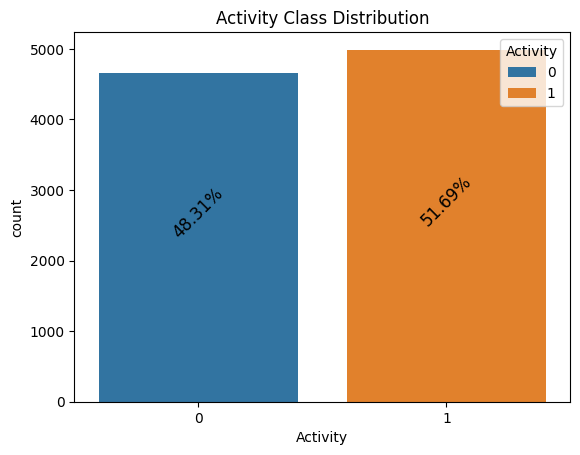

In [28]:
sns.countplot(x='Activity', data=df, hue='Activity')

for i in range(len(df['Activity'].unique())):
    data_len = df.shape[0]
    count = len(df[df['Activity'] == i])
    
    text = round((count/data_len)*100, 2)
    plt.text(i, count/2, str(text) + '%', rotation=45, ha='center', fontsize=12)
plt.title('Activity Class Distribution')
plt.savefig(r'..\plots\activity_distribution.png')
plt.show()

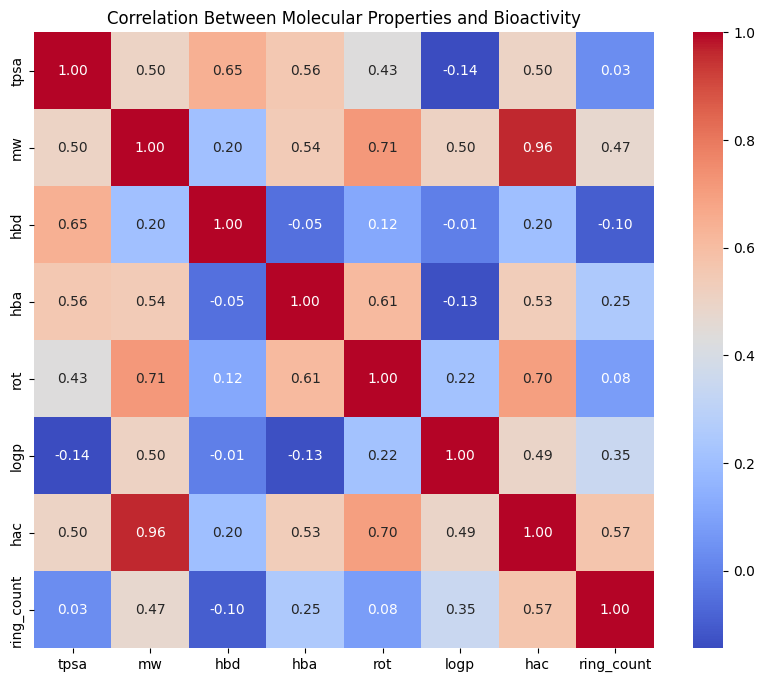

In [142]:
features = ['tpsa', 'mw', 'hbd', 'hba', 'rot', 'logp', 'hac', 'ring_count']

corr = df[features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Molecular Properties and Bioactivity")
plt.savefig(r'..\plots\correlation_matrix.png')
plt.show()

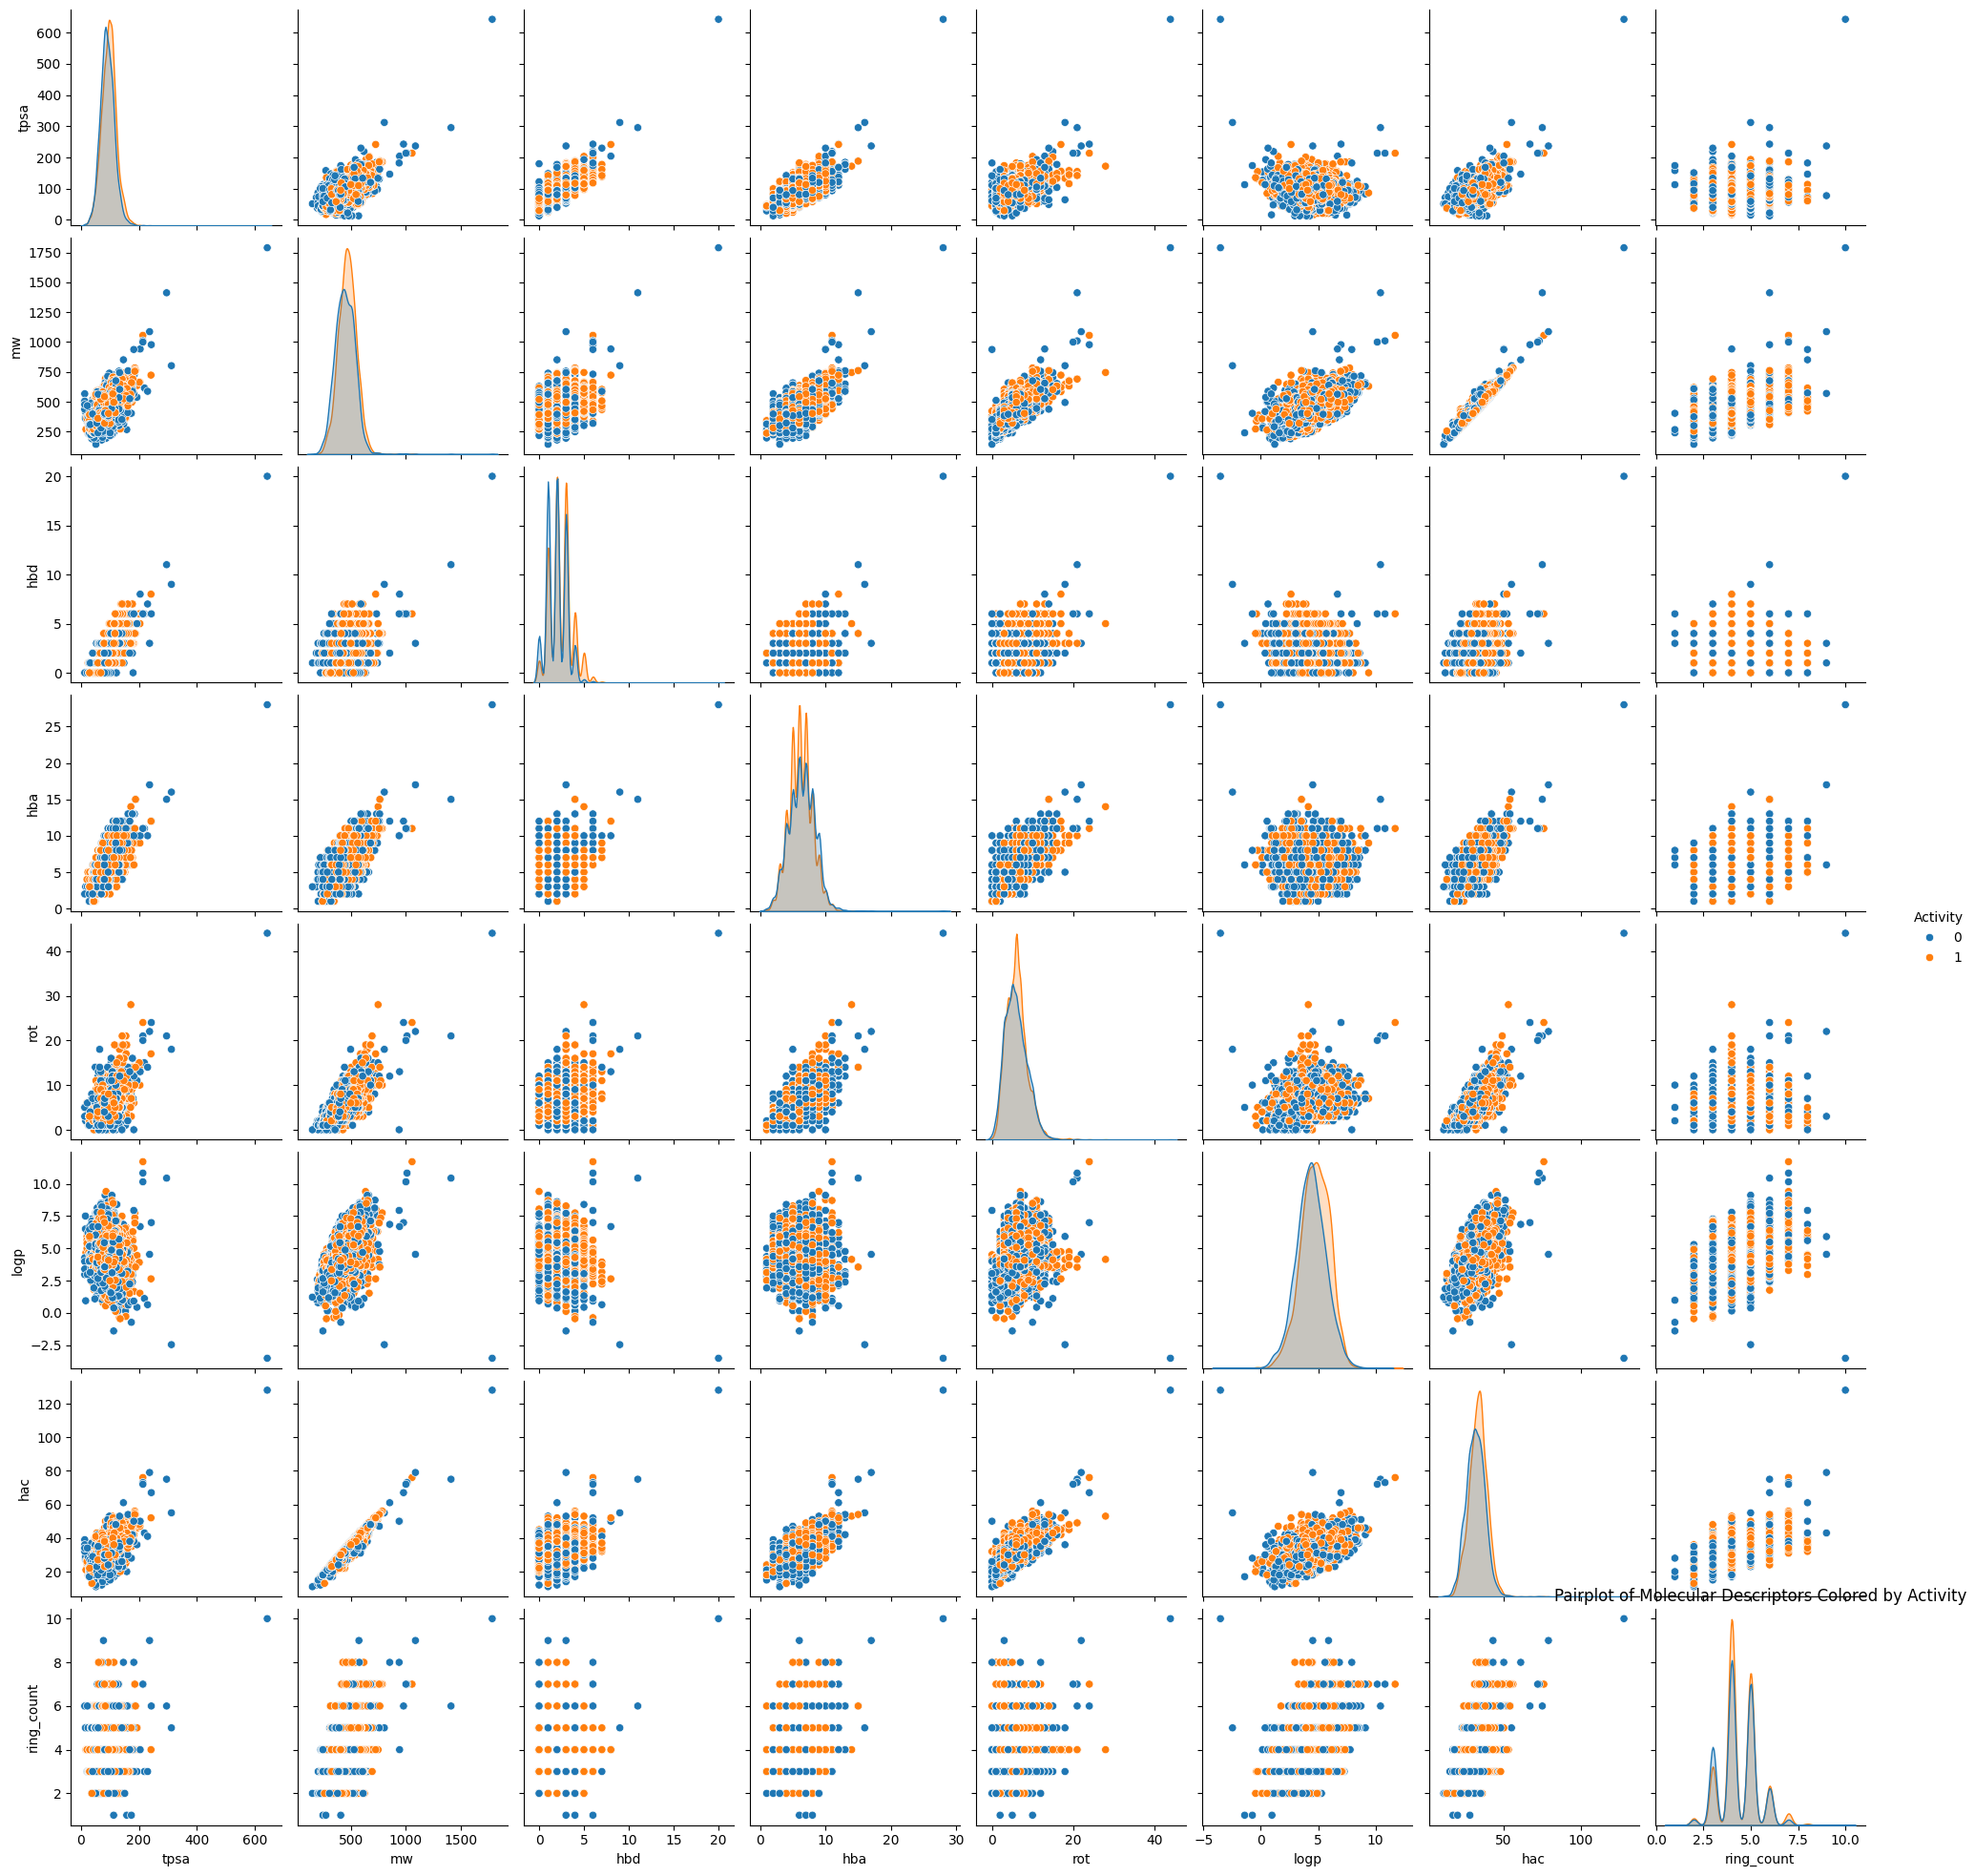

In [143]:
sns.pairplot(df.dropna(), hue='Activity')
plt.title("Pairplot of Molecular Descriptors Colored by Activity")
plt.savefig(r'..\plots\pairplot.png')
plt.show()

**Class balance**  
The activity classes are fairly balanced, providing a good basis for supervised learning.

**High Redundancy**  
- `Heavy atom count` has very high correlation with `Molecular Weight`, as molecular wieght is important properties of the compounds (by means of lipinksi rule of 5), will dorp `hac` column. 
- For else columns there us no significant correlation copmared to `hac`.

**Independent**
- `logP` and `ring count` has the lowest correlation and other features are mostly below `0.50`, this will valuable for model to sort the compounds into there respective classes.

**Active sweet spot**
The oragne pointss(active compunds) are not randomly scattered; they clustoer in specific ranges
- **Molecular Weight**: Mostly concentrated between 250 and 750.
- **LopP**: Mostly centred between 2-5.
- **TPSA**: Active molecules rarely exceed 150.

***Before train the column should normalize for models like logistic regression***

# Model Training

## Models

Baseline:
- Logistic Regression
- Random Forest

Advanced:
- XGBoost
- Neural Network (TensorFlow)


## 1. Baseline models

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [30]:
def metric_report(y_true, y_pred, model_name, model, save: bool = False):
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))
    
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f'The ROC-AUC score for {model_name} is: {roc_auc:.4f}\n')
    
    importances = model.feature_importances_
    fi = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x="Importance", y="Feature", data=fi)
    plt.title(f"Feature Importance ({model_name})")
    if save:
        plt.savefig(fr'..\plots\feature_importance_{model_name}.png')
    plt.show()
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    if save:
        plt.savefig(fr'..\plots\confusion_matrix_{model_name}.png')
    plt.show()

In [32]:
features = ['tpsa', 'mw', 'hbd', 'hba', 'rot', 'logp', 'ring_count']
label = 'Activity'

X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[label], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df[label]
                                                    )

In [156]:
# Logistic Regression Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('norm', StandardScaler(), ['logp', 'ring_count']),
        ('skewed', PowerTransformer(), ['tpsa', 'mw', 'hba', 'hbd', 'rot'])
    ])

pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=100))
])

pipe_lr.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('norm', ...), ('skewed', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers 

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       932
           1       0.60      0.65      0.62       998

    accuracy                           0.59      1930
   macro avg       0.59      0.59      0.59      1930
weighted avg       0.59      0.59      0.59      1930

The ROC-AUC score for Logistic Regression is: 0.5908



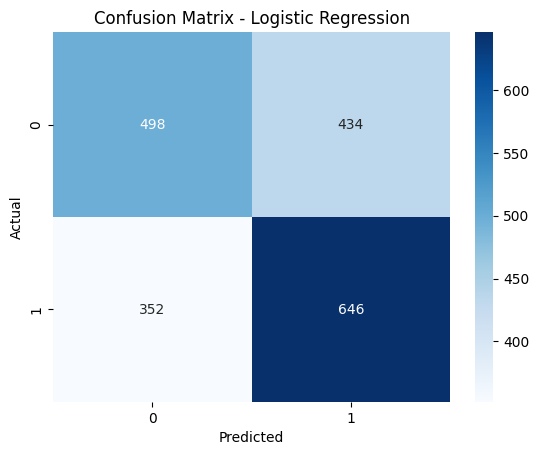

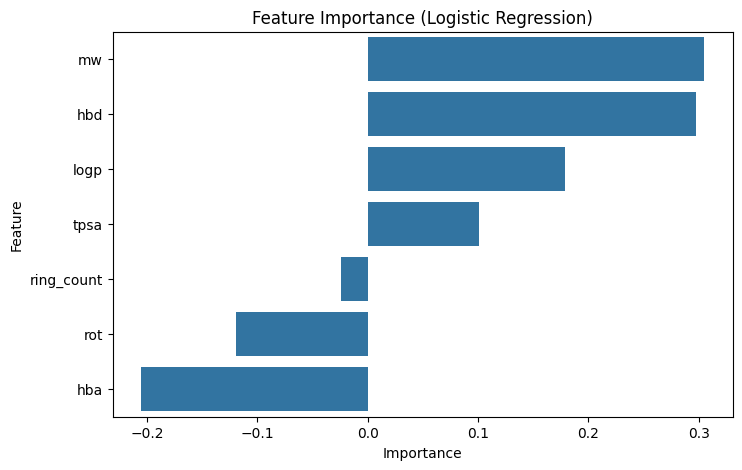

In [157]:
y_pred = pipe_lr.predict(X_test)

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred)
print(f'The ROC-AUC score for Logistic Regression is: {roc_auc:.4f}\n')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")

importance = pipe_lr.named_steps['clf'].coef_[0]
lr_feature_names = ['logp', 'ring_count', 'tpsa', 'mw', 'hba', 'hbd', 'rot']

fi = pd.DataFrame({
    "Feature": lr_feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi)
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [33]:
# Random Forest
rf = RandomForestClassifier(random_state=45)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       932
           1       0.74      0.75      0.74       998

    accuracy                           0.73      1930
   macro avg       0.73      0.73      0.73      1930
weighted avg       0.73      0.73      0.73      1930

The ROC-AUC score for Random Forest is: 0.7327



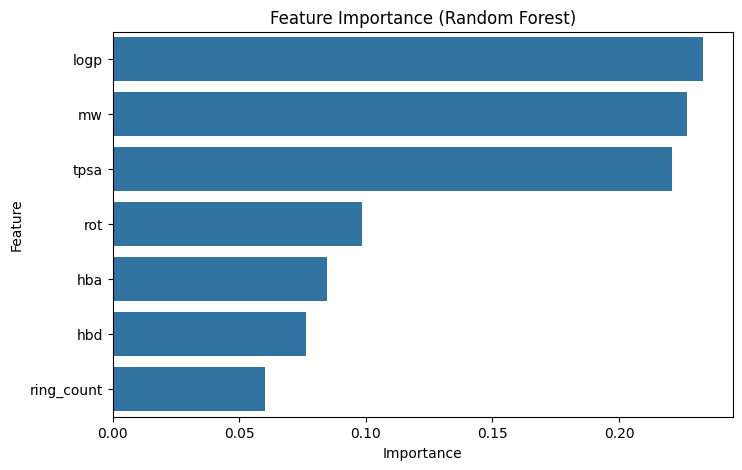

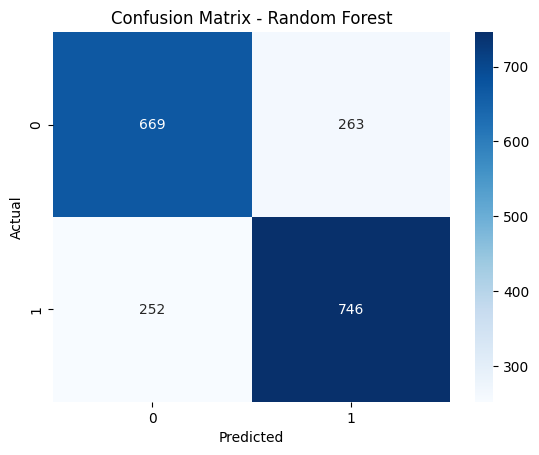

In [34]:
y_pred = rf.predict(X_test)

metric_report(y_test, y_pred, "Random Forest", rf, save=True)

## 2. Advance models

In [153]:
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

In [154]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       932
           1       0.71      0.71      0.71       998

    accuracy                           0.70      1930
   macro avg       0.70      0.70      0.70      1930
weighted avg       0.70      0.70      0.70      1930

The ROC-AUC score for XGBoost is: 0.7007



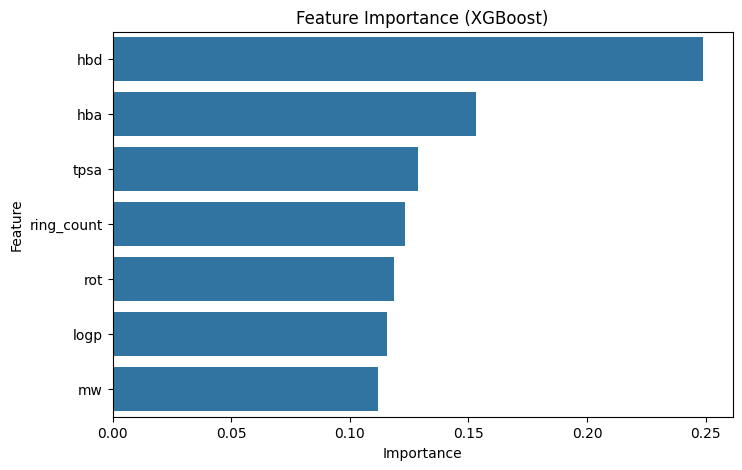

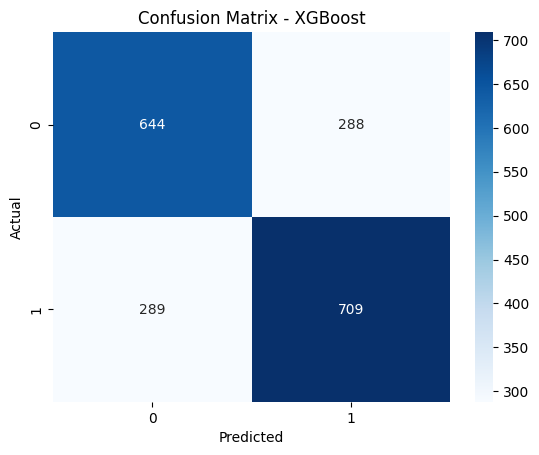

In [ ]:
y_prob = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

metric_report(y_test, y_pred, "XGBoost", xgb)

### Neural Network

In [ ]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled  = preprocessor.transform(X_test)

In [ ]:
X_train.shape

(7718, 7)

In [ ]:
model = Sequential([
    Input(shape=(7,)),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation="relu"),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(0.001),
    loss="binary_crossentropy",
    metrics=[Precision(name="precision"),
            Recall(name="recall"),
            AUC(name="auc")]
)


In [ ]:
model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=64,
    verbose=1
)


Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - auc: 0.6177 - loss: 0.7067 - precision: 0.6046 - recall: 0.5846 - val_auc: 0.6385 - val_loss: 0.6823 - val_precision: 0.5326 - val_recall: 0.9098
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6592 - loss: 0.6566 - precision: 0.6196 - recall: 0.6385 - val_auc: 0.6587 - val_loss: 0.6611 - val_precision: 0.5768 - val_recall: 0.8016
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.6680 - loss: 0.6516 - precision: 0.6336 - recall: 0.6533 - val_auc: 0.6844 - val_loss: 0.6368 - val_precision: 0.6461 - val_recall: 0.6513
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.6888 - loss: 0.6381 - precision: 0.6534 - recall: 0.6455 - val_auc: 0.7046 - val_loss: 0.6243 - val_precision: 0.6391 - val_recall: 0.7204
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.6900 - loss: 0.6353 - precision: 0.6444 - recall: 0.6460 - val_auc: 0.7163 - val_loss: 0.6161 - val_precision: 0.6650 - val_recall: 0.

In [ ]:
results = model.evaluate(X_test_scaled, y_test)

print("Loss:", results[0])
print("Precision:", results[1])
print("Recall:", results[2])
print("AUC:", results[3])

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7891 - loss: 0.5647 - precision: 0.7475 - recall: 0.6764
Loss: 0.5646758675575256
Precision: 0.7475082874298096
Recall: 0.6763526797294617
AUC: 0.7891184091567993


In [ ]:
y_pred_prob = model.predict(X_test_scaled)

# Convert to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print matrix
print('The confusion matrix is:\n', cm)


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       932
           1       0.75      0.68      0.71       998

    accuracy                           0.71      1930
   macro avg       0.72      0.72      0.71      1930
weighted avg       0.72      0.71      0.71      1930

The confusion matrix is:
 [[704 228]
 [323 675]]


## Model Performance

| Model | ROC-AUC | F1 |
|-------|--------|--------|
Logistic Regression | 0.59 | 0.59
Random Forest | 0.73 | 0.73
XGBoost | 0.70 | 0.71
Neural Network | 0.79 | 0.71

Although the `Neural Network model` achieved the highest ROC-AUC and F1-scores, the `Random Forest` was selected as the final model for deployment.  

| Metric            | Neural Network | Random Forest |
|-------------------|----------------|----------------|
| **TN**            | 704            | 669            |
| **FP**            | 228            | 263            |
| **FN**            | 323            | 252            |
| **TP**            | 675            | 746            |
| **F1 (Inactive)** | 72             | 72             |
| **F1 (Active)**   | 72             | 74             |

1. **The F1 score for both classes and confusion martix for Random Forest was far bettere than Neural Network model**, `Neural Network model` was good at predicting inactives but bad at active as compared to `Random Forest`.   

2. The feature importance analysis showed that ***`LogP`***, ***`Molecular wieght`***, and ***`TPSA`*** are the most influential descriptors, which aligns well with known structure–activity relationships for the selected target, this also matches our **EDA analysis**.

Therefore, the most importance feature for our best model, `Random forest` are (most to least importance):
- 1. `logP`
- 2. `molecular weight`
- 3. `TPSA`
- 4. `no. of rotatable bonds`
- 5. `no. hydrogen bond acceptor`
- 6. `no. hydrogen bond donar`
- 7. `ring count`

In this project, compounds with `IC50 values` below `200 nM` were labeled as `Active`. Therefore, the `Random Forest` learns to distinguish highly potent molecules from weaker or inactive compounds while providing transparent explanations.



# Best Model
* The best model the current dataset is Random Forest Classifier

In [35]:
rf_explainer_wo_fp = shap.TreeExplainer(rf, X_train)
rf_shap_values_wo_fp = rf_explainer_wo_fp(X_test)

100%|===================| 3843/3860 [02:31<00:00]        

In [41]:
inactive = rf_shap_values_wo_fp[17, :, 0]
active = rf_shap_values_wo_fp[12, :, 1]

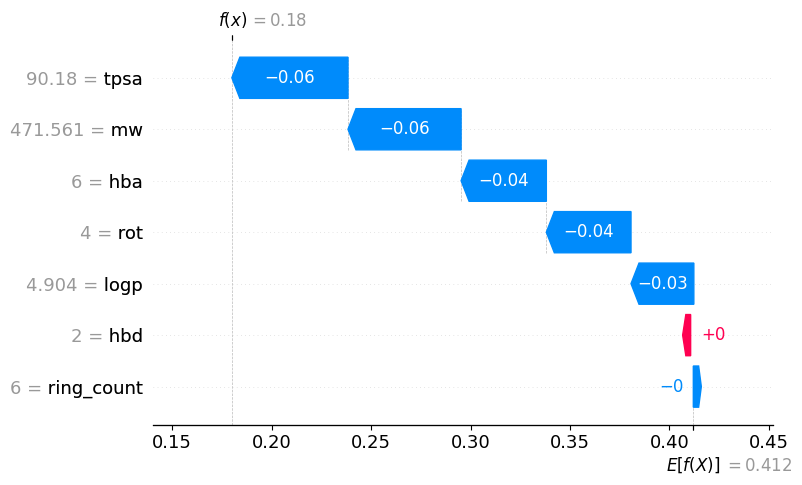

In [42]:
shap.waterfall_plot(inactive, show=False)
plt.savefig(r'..\plots\shap_waterfall_inactive.png', dpi=300, bbox_inches="tight")
plt.show()

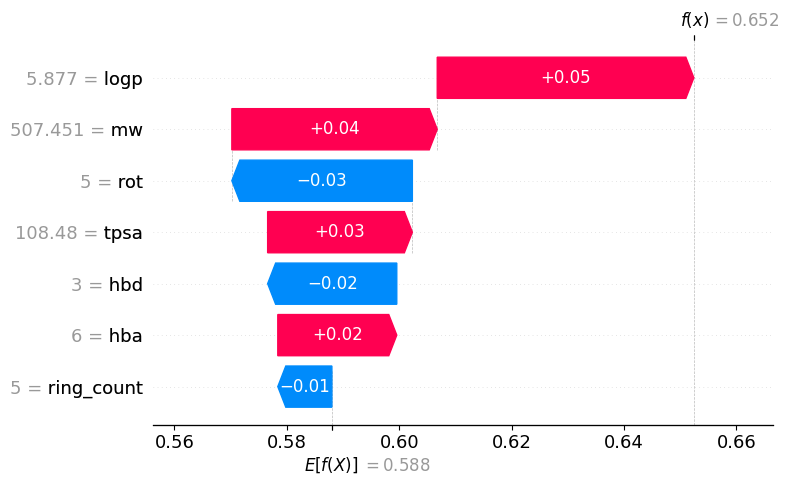

In [37]:
shap.waterfall_plot(active, show=False)
plt.savefig(r'..\plots\shap_waterfall_active.png', dpi=300, bbox_inches="tight")
plt.show()

## Explainability

Feature importance analysis showed:

- As seen in most important features, `logP` and `molecular weight` where seen contributing to activity of the `CHEMBL279`.

- This indicates **lipophilicity** and **molecular weight** dominate `CHEMBL279`'s binding, which is also seen in our `EDA`.

# Saving the model

In [ ]:
import pickle
# with open(r'..\models\best_model(rf).pkl', 'wb') as f:
#     pickle.dump(rf, f)

# Add more feature to increase the ROC-AUC, F1 and overall classification

In [88]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display

In [40]:
df.head(1)

,Activity,canonical_smiles,tpsa,mw,hbd,hba,rot,logp,hac,ring_count
0,0,Nc1ccccc1NC(=O)c1ccc(C(=O)Nc2cccc(Nc3ncc(-c4cc...,122.03,512.62,4.0,8.0,7.0,6.097,36.0,5.0


In [41]:
def morgan_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    generator = rdFingerprintGenerator.GetMorganGenerator(
        radius=radius,
        fpSize=nBits
    )
    fp = generator.GetFingerprint(mol)
    return np.array(fp)

In [42]:
df['fp'] = df['canonical_smiles'].apply(morgan_fp)

In [43]:
features = ['tpsa', 'mw', 'hbd', 'hba', 'rot', 'logp', 'ring_count']

In [44]:
X_desc = df[features].values
  
cols = [f"fp_{i+1}" for i in range(2048)]
X = pd.concat([df[features], pd.DataFrame(np.stack(df.fp.values), columns=cols)], axis=1)

y = df['Activity']

In [45]:
X.shape

(9648, 2055)

In [94]:
X_train_fp, X_test_fp, y_train_fp, y_test_fp = train_test_split(X, 
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y
                                                    )

In [95]:
X_train_fp.shape

(7718, 2055)

In [96]:
rf.fit(X_train_fp, y_train_fp)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       932
           1       0.83      0.85      0.84       998

    accuracy                           0.83      1930
   macro avg       0.83      0.83      0.83      1930
weighted avg       0.83      0.83      0.83      1930

The ROC-AUC score for Random Forest (with Morgan Fingerprints) is: 0.8336



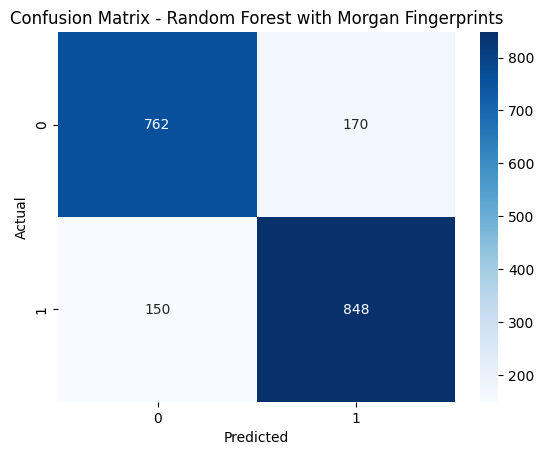

In [97]:
y_pred = rf.predict(X_test_fp)

print(classification_report(y_test_fp, y_pred))

roc_auc = roc_auc_score(y_test_fp, y_pred)
print(f'The ROC-AUC score for Random Forest (with Morgan Fingerprints) is: {roc_auc:.4f}\n')

cm = confusion_matrix(y_test_fp, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest with Morgan Fingerprints")
plt.show()


In [98]:
features

['tpsa', 'mw', 'hbd', 'hba', 'rot', 'logp', 'ring_count']

In [99]:
importances = rf.feature_importances_

feature_names = features + cols  

fi = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

fi.head(5)

,Feature,Importance
1,mw,0.021836
5,logp,0.019279
0,tpsa,0.014767
4,rot,0.009718
3,hba,0.007929


In [51]:
rf_explainer = shap.TreeExplainer(rf, X_train_fp)
rf_shap_values = rf_explainer(X_test_fp, check_additivity=False)

100%|===================| 3849/3860 [03:14<00:00]        

In [52]:
inactive = rf_shap_values[18, :, 0]
active = rf_shap_values[12, :, 1]

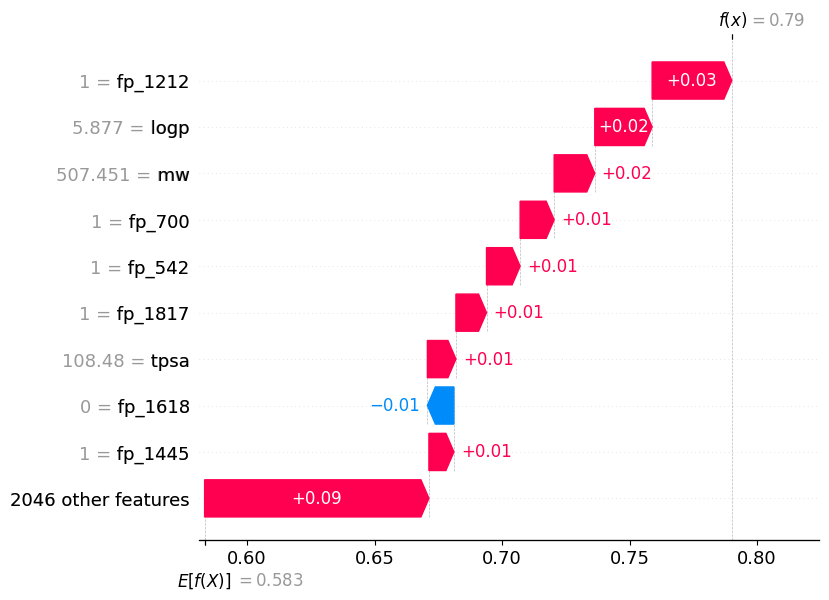

In [53]:
shap.waterfall_plot(active, show=False)
plt.savefig(r'..\plots\fp_model_shap_waterfall_active.png', dpi=300, bbox_inches="tight")
plt.show()

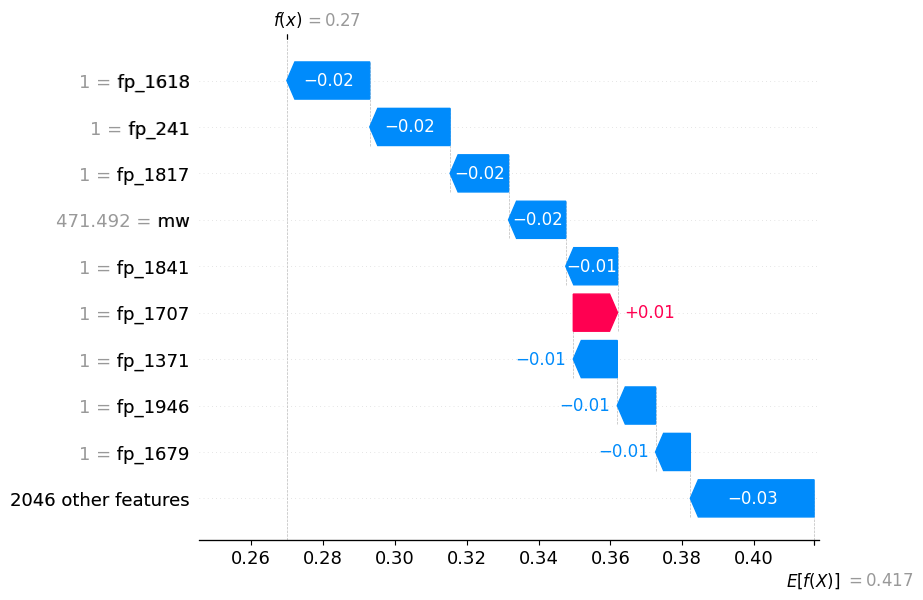

In [54]:
shap.waterfall_plot(inactive, show=False)
plt.savefig(r'..\plots\fp_model_shap_waterfall_inactive.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
fi[fi['Feature'].str.startswith('fp_')].head(10).sort_values(by="Importance", ascending=False)

,Feature,Importance
1624,fp_1618,0.007744
1377,fp_1371,0.006374
657,fp_651,0.005948
1298,fp_1292,0.005591
63,fp_57,0.005539
191,fp_185,0.004628
1996,fp_1990,0.004624
814,fp_808,0.004582
1823,fp_1817,0.004503
329,fp_323,0.003740


In [84]:
df.loc[df['Activity'] == 1]['canonical_smiles'][5]

'Cc1ccc(O)cc1Nc1ccnc2c1C(=O)Nc1cc(CNCC(N)=O)ccc1N2'

Active Molecules


[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator


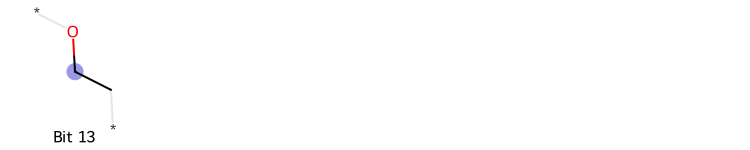

[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator


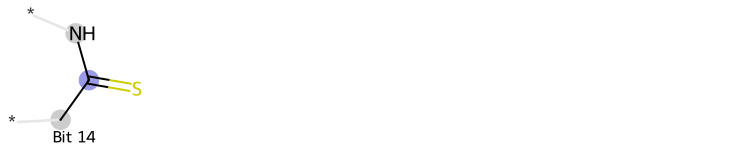

Inactive Molecules


[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator


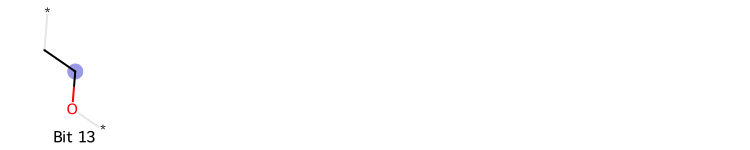

[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator


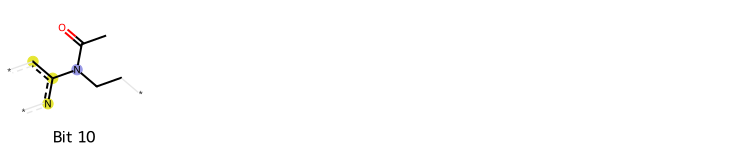

[08:48:48] DEPRECATION WARNING: please use MorganGenerator


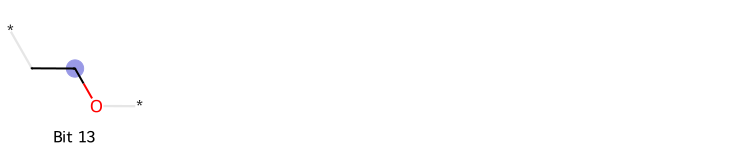

[08:48:48] DEPRECATION WARNING: please use MorganGenerator
[08:48:48] DEPRECATION WARNING: please use MorganGenerator


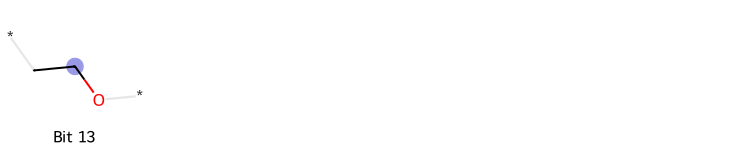

In [93]:
def draw_top_morgan_bits(smiles_list):
    importances = [57, 185, 241, 323, 542, 651, 700, 808, 1212, 1292, 1371, 1445, 1618, 1679, 1707, 1817, 1946, 1990]
    top_indices = np.argsort(importances)[::-1][:10]    
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            bit_info = {}
            AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bit_info)
            bits_to_draw = [bit for bit in top_indices if bit in bit_info]
            
            # The fix: Only draw if there are bits to show
            if bits_to_draw:
                img = Draw.DrawMorganBits([(mol, bit, bit_info) for bit in bits_to_draw], 
                                         molsPerRow=5, 
                                         legends=[f"Bit {b}" for b in bits_to_draw])
                display(img)

active_smiles = df[df['Activity']==1].canonical_smiles[:10].tolist()
inactive_smiles = df[df['Activity']==0].canonical_smiles[:10].tolist()

def separator(text):
    print('='*100)
    print(text)
    print('='*100)

separator("Active Molecules")
draw_top_morgan_bits(active_smiles)

separator("Inactive Molecules")
draw_top_morgan_bits(inactive_smiles)

In [ ]:
# with open(r'..\models\best_model(rf_with_fp).pkl', 'wb') as f:
#     pickle.dump(rf, f)